## Red Neuronal (2 capas)

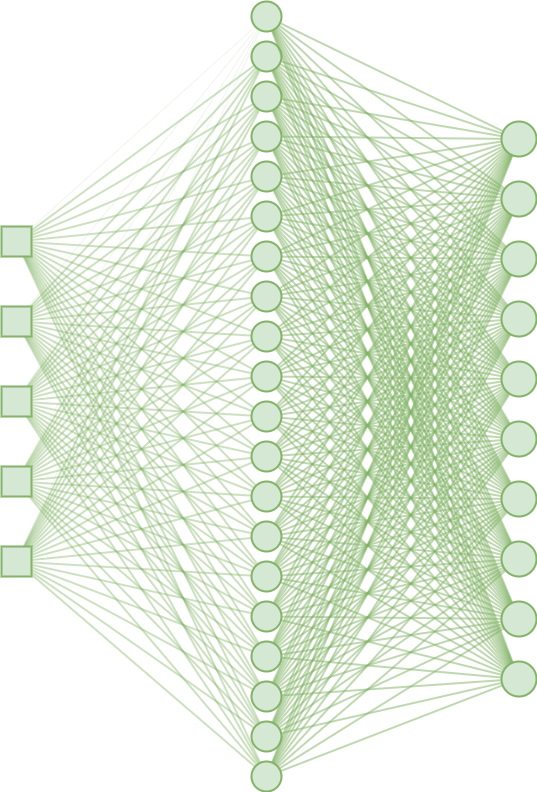

### Instalación de dependencias

In [ ]:
%%capture
uv pip install numpy matplotlib scikit-learn seaborn

### Importar librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Importar MNIST 

In [ ]:
from get_images import get_images

In [ ]:
# MNIST path
mnist_path = '../data/mnist'

In [ ]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [ ]:
x_test_num.shape

In [ ]:
28*28

### Convertir imágenes en vectores, y a float32

In [ ]:
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000, 1)

In [ ]:
print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

### Graficar algunas imágenes

In [ ]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [ ]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$


### Red Neuronal
### Dos capas 200-10

### Crear 'Mini-batches'

In [ ]:
x_train.shape[0]

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    Divide el dataset en mini-batches para entrenamiento eficiente.
    
    Parámetros:
    -----------
    mb_size : int
        Tamaño del mini-batch (número de muestras por lote)
    x : numpy.ndarray
        Datos de entrada con forma (num_muestras, 784)
    y : numpy.ndarray
        Etiquetas con forma (num_muestras, 1)
    shuffle : bool, opcional
        Si True, mezcla los datos antes de dividirlos (default: True)
    
    Retorna:
    --------
    generator
        Generador que produce tuplas (x_batch, y_batch) en cada iteración
    '''
    # Verificar que x e y tengan el mismo número de muestras
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    
    # Mezclar datos aleatoriamente si shuffle=True
    if shuffle: 
        idxs = np.arange(total_data)  # Crear índices [0, 1, 2, ..., n-1]
        np.random.shuffle(idxs)        # Mezclar índices aleatoriamente
        x = x[idxs]                    # Reordenar x según índices mezclados
        y = y[idxs]                    # Reordenar y de la misma manera
    
    # Generar mini-batches: dividir datos en lotes de tamaño mb_size
    # range(0, total_data, mb_size) genera: 0, mb_size, 2*mb_size, ...
    # Cada iteración retorna un batch (x[i:i+mb_size], y[i:i+mb_size])
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Inicio de parametros

In [ ]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> elementos de entrada, 784
    neurons -> list [200, 10] con cantidad de neuronas en cada capa
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [ ]:
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b1'].shape)
print(parameters['b2'].shape)

### Función de activación ReLU

ReLU (Rectified Linear Unit) devuelve el máximo entre 0 y el valor de entrada. Introduce no-linealidad en la red neuronal.

In [ ]:
def relu(x):
    return np.maximum(0, x)

### Forward Pass

Calcula la salida de la red neuronal pasando los datos a través de las dos capas:
- Capa 1: Entrada → ReLU(W1·X + b1) → a1
- Capa 2: a1 → W2·a1 + b2 → scores (sin activación)

In [ ]:
def forward_pass(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [ ]:
scores_test, z1, a1 = forward_pass(x_train[:64].T, parameters, relu)

In [ ]:
x_train[:64].T.shape

In [ ]:
scores_test.shape

### Función Softmax

Convierte los scores en probabilidades normalizadas que suman 1. Cada valor representa la probabilidad de que la entrada pertenezca a cada clase (0-9).

In [ ]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

### Cross-Entropy Loss

Calcula el costo (error) entre las predicciones y los valores reales. Penaliza fuertemente las predicciones incorrectas con alta confianza.

In [ ]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

### Backward Propagation

Calcula los gradientes (derivadas) de la función de costo respecto a cada peso y bias usando la regla de la cadena. Estos gradientes indican cómo ajustar los parámetros para reducir el error.

In [ ]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    # Inicializar diccionario para almacenar gradientes
    grads = {}
    
    # PASO 1: Calcular gradiente de la capa de salida (Capa 2)
    # probs contiene las probabilidades softmax (y_hat)
    # Restamos 1 en la posición de la clase correcta: derivada de (softmax + cross-entropy)
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # y_hat - y (error de predicción)
    dz2 = probs.copy()  # dz2 = gradiente respecto a z2 (scores antes de softmax)
    
    # PASO 2: Calcular gradientes de W2 y b2 (capa de salida)
    # dW2 = ∂L/∂W2 = dz2 · a1^T / batch_size
    dW2 = dz2 @ a1.T / batch_size  # Multiplicar error por activaciones de capa anterior y promediar
    # db2 = ∂L/∂b2 = suma de errores por columna (cada muestra) dividido batch_size
    db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size  # Sumar errores y mantener dimensión (10,1)
    
    # PASO 3: Propagar error hacia atrás a la capa oculta
    # da1 = ∂L/∂a1 = W2^T · dz2 (multiplicar error por pesos transpuestos)
    da1 = parameters['W2'].T @ dz2  # Retropropagar error a través de W2
    
    # PASO 4: Aplicar derivada de ReLU
    # Derivada de ReLU: 1 si z1 > 0, sino 0
    dz1 = da1.copy()  # Copiar gradiente de activaciones
    dz1[z1 <= 0] = 0  # Anular gradientes donde z1 fue negativo (ReLU=0)
    
    # PASO 5: Calcular gradientes de W1 y b1 (capa oculta)
    # dW1 = ∂L/∂W1 = dz1 · x^T / batch_size
    dW1 = dz1 @ x.T / batch_size  # Multiplicar error por entradas transpuestas y promediar
    # db1 = ∂L/∂b1 = suma de errores por columna dividido batch_size
    db1 = np.sum(dz1, axis=1, keepdims=True) / batch_size  # Sumar errores y mantener dimensión (200,1)
    
    # PASO 6: Verificar que las dimensiones de gradientes coincidan con parámetros
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'  # W1: (200,784) == dW1
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'  # W2: (10,200) == dW2
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'  # b1: (200,1) == db1
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'  # b2: (10,1) == db2
    
    # PASO 7: Empaquetar todos los gradientes en un diccionario
    grads = {'w1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    
    # Retornar gradientes para actualizar parámetros en train()
    return grads

In [ ]:
y_hat, cost = x_entropy(scores_test, y_train[:64])

In [ ]:
y_hat.shape

In [ ]:
print(cost)

In [ ]:
grads = backward(y_hat, x_train[:64].T, y_train[:64], z1, a1, scores_test, parameters)

### Función de Accuracy

Calcula el porcentaje de predicciones correctas dividiendo el conjunto de datos en mini-batches.

In [ ]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = forward_pass(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

### Función de Entrenamiento

Implementa el algoritmo de descenso de gradiente en mini-batches:
1. Forward pass: calcula predicciones
2. Calcula el costo
3. Backward pass: calcula gradientes
4. Actualiza parámetros: W = W - learning_rate × gradient


In [ ]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch, _ in enumerate(range(epochs)):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = forward_pass(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x.T, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'Epoch {epoch+1} - costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters
    

### Entrenar el modelo

Configuración:
- **Mini-batch size**: 512 imágenes por iteración
- **Learning rate**: 0.01 (tasa de aprendizaje)
- **Epochs**: 20 pasadas completas sobre el dataset

In [ ]:
mb_size = 64
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

In [ ]:
accuracy(x_train, y_train, mb_size)

### Evaluar Accuracy

Verificamos el rendimiento en los conjuntos de entrenamiento y test.

In [ ]:
accuracy(x_test, y_test, mb_size)

### Función de Predicción

Realiza forward propagation y retorna la clase con mayor probabilidad (argmax).

In [ ]:
def predict(x):
    scores2, _, _ = forward_pass(x, parameters, relu)
    return np.argmax(scores2)

In [ ]:
x_test[0].reshape(-1, 1).shape

### Probar predicción individual

Seleccionamos una imagen aleatoria del conjunto de test y visualizamos la predicción del modelo.

In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')

### Matriz de Confusión

Evaluamos el desempeño del modelo en el conjunto de test mediante una matriz de confusión.

In [ ]:
# Obtener predicciones para todo el conjunto de test
y_pred = []
for i in range(len(x_test)):
    pred = predict(x_test[i].reshape(-1, 1))
    y_pred.append(pred)
y_pred = np.array(y_pred)

In [ ]:
# Crear matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.squeeze(), y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Conjunto de Test')
plt.show()

In [ ]:
# Accuracy final del modelo en el conjunto de test
test_accuracy = accuracy(x_test, y_test, mb_size)
print(f'Accuracy en el conjunto de test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')